In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from solardatatools import DataHandler
from spcqe.quantiles import SmoothPeriodicQuantiles

from utils.load_redshift_data import load_redshift_data
import utils.dilatation as dilatation

/var/folders/b5/mtl69w8n2n19ms1v6b8fvy5r0000gn/T/ipykernel_15529/27690707.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## With PV data

In [3]:
query = {
'siteid': "TADBC1078041",
'api_key': os.environ.get('REDSHIFT_API_KEY'),
'sensor': 0
}
df = load_redshift_data(**query)
dh = DataHandler(df, convert_to_ts=True)
dh.run_pipeline()

/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  meas_name = str(df_view[name_key][0])
/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if avg_day[0] >= thresh:
/Users/aramis/miniconda3/envs/spcqe-dev/lib/python3.11/site-packages/solardatatools/time_axis_manipulation.py:152: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

total time: 54.54 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              13.90s
Cleaning                   0.64s
Filtering/Summarizing      40.00s
    Data quality           0.35s
    Clear day detect       0.83s
    Clipping detect        21.42s
    Capacity change detect 17.39s



In [4]:
# For now, dilatation can not handle NaNs. We us the filled data matrix, dilate, then add the NaNs again. It will change it soon.
signal_series = pd.Series(
    data= dh.filled_data_matrix.ravel(order='F') / dh.capacity_estimate,
    index = dh.data_frame.index
    )
sunrises = dh.daytime_analysis.sunrise_estimates
sunsets = dh.daytime_analysis.sunset_estimates

In [5]:
nvals_ori = dh.raw_data_matrix.shape[0]
nvals_dil = 101
ndays = 700

In [6]:
# Dilatation
# Indexes have 1 more value than the signals (the right boundary of the last bin)
idx_ori = dilatation.build_original_idx(signal_series, nvals_ori)
idx_dil = dilatation.build_dilated_idx(sunrises, sunsets, idx_ori, nvals_dil)
signal_ori = signal_series.to_numpy()
signal_dil = dilatation.dilate_signal(idx_dil, idx_ori, signal_ori)

In [7]:
# Add NaNs again
_sig = signal_ori.reshape((nvals_ori, dh.raw_data_matrix.shape[1]), order='F')
nan_mask_ori = np.tile(dh.daily_flags.no_errors, (nvals_ori, 1))
_sig[~nan_mask_ori] = np.nan
signal_ori = _sig.ravel(order='F')

_sig = signal_dil[1:].reshape((nvals_dil, dh.raw_data_matrix.shape[1]), order='F')
nan_mask_dil = np.tile(dh.daily_flags.no_errors, (nvals_dil, 1))
_sig[~nan_mask_dil] = np.nan
signal_dil[1:] = _sig.ravel(order='F')

In [8]:
# Crop
idx_ori = idx_ori[0*nvals_ori:ndays*nvals_ori+2] # starts at the first midnight, ends 24h/nvlas_ori after the ndays-th midnight
signal_ori = signal_ori[0*nvals_ori:ndays*nvals_ori+1]
idx_dil = idx_dil[0*nvals_dil:ndays*nvals_dil+2]  # starts at the first midnight, ends at the first sunrise after the ndays-th midnight
signal_dil = signal_dil[0*nvals_dil:ndays*nvals_dil+1]

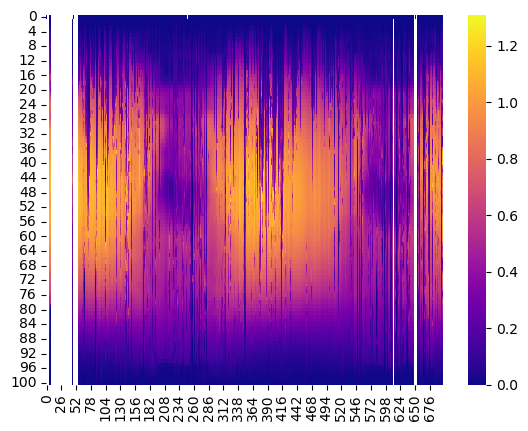

In [9]:
sns.heatmap(signal_dil[:-1].reshape((nvals_dil, ndays), order='F'), cmap='plasma');

In [10]:
def plot_quantiles(q, fq):
    fig, ax = plt.subplots(6, 2, figsize=(8, 15))
    for i in range(len(q)):
        sns.heatmap(fq[1:, i].reshape((nvals_dil, ndays), order='F'), ax=ax[i//2, i%2], cmap='plasma')
        ax[i//2, i%2].set_title(f'Quantile {q[i]}')
    plt.tight_layout()
    return plt.gca()

In [11]:
my_quantiles = [0.02, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.98]

In [48]:
osd = SmoothPeriodicQuantiles(num_harmonics=[3,2],
                              periods=[nvals_dil, 365.24225*nvals_dil],
                              standing_wave=[False, False],
                              trend=False,
                              quantiles=my_quantiles,
                              weight=0,
                              solver='OSD',
                              custom_basis=None)
osd.fit(signal_dil)

100%|███████████████████████████████████████████| 11/11 [05:14<00:00, 28.61s/it]


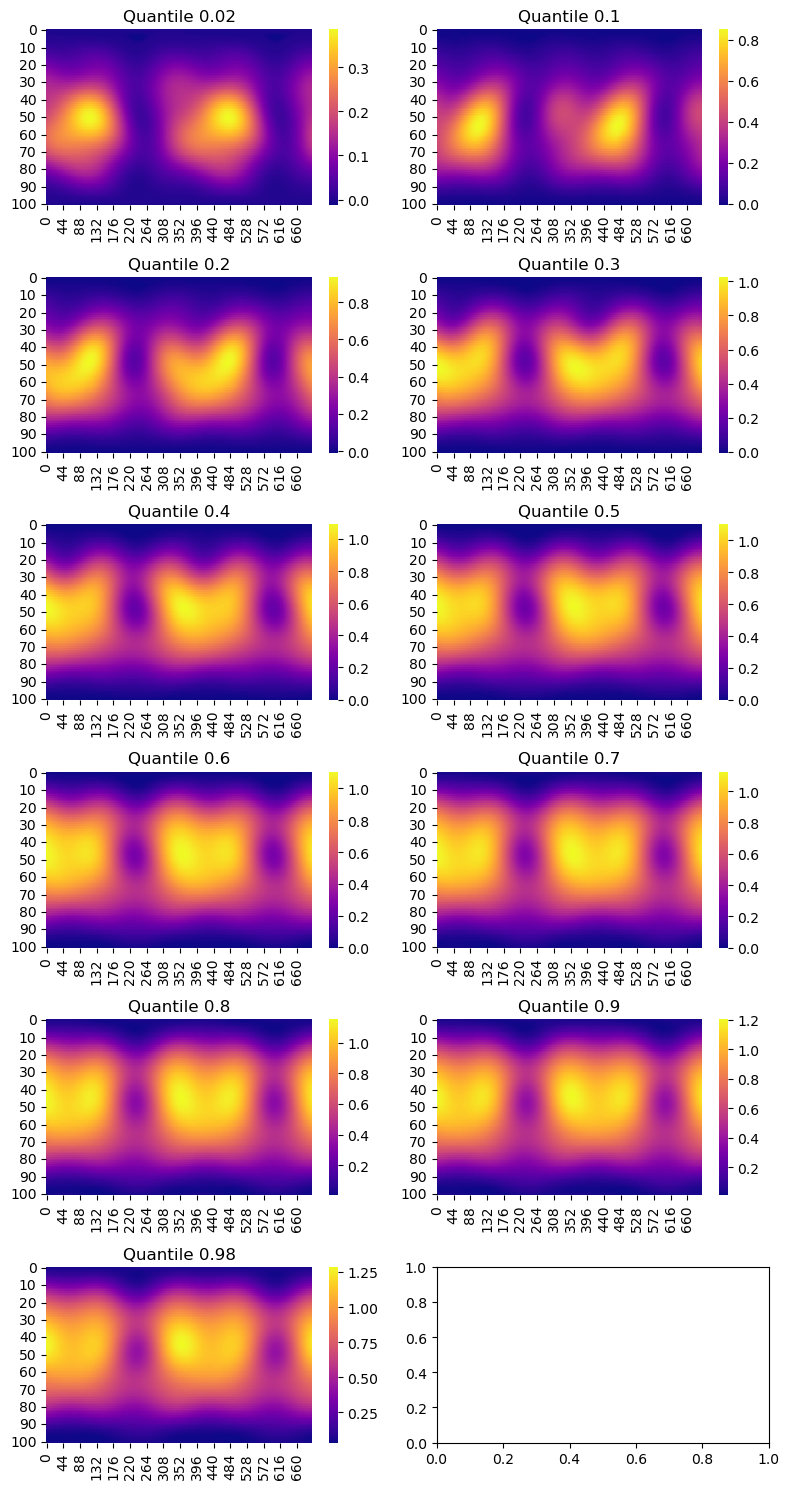

In [49]:
plot_quantiles(my_quantiles, osd.fit_quantiles);

In [12]:
mosek = SmoothPeriodicQuantiles(num_harmonics=[3,2],
                                periods=[nvals_dil, 365.24225*nvals_dil],
                                standing_wave=[False, False],
                                trend=False,
                                quantiles=my_quantiles,
                                weight=0,
                                solver='MOSEK',
                                custom_basis=None)
mosek.fit(signal_dil)

In [ ]:
plot_quantiles(my_quantiles, mosek.fit_quantiles);